In [31]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import statistics

#Reading data from csv file
df = pd.read_csv('Stock_Review.csv')
price = df['UCLA'].values.reshape(-1,1)

In [32]:
#Normalizing training data
scaler = StandardScaler()
scaler.fit(price[: (1 * len(price)) // 3])
price = scaler.transform(price).flatten()



In [33]:
#We use T past values to predict next value
#Our data has D dimention
#Now we start to build data set
T = 10
D = 1
X = []
Y = []
for t in range(len(price) - T):
    x = price[t:t+T]
    X.append(x)
    y = price[t+T]
    Y.append(y)
X = np.array(X).reshape(-1,T,1) #Data should be N * T * D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)


X.shape (495, 10, 1) Y.shape (495, 1)


In [34]:
#Thsi is our model. LSTM model with M hidden cells and L layers
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True,
            dropout=0.1)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        out, _ = self.rnn(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [35]:
#Now we call our model with arbitary inputs
#We define our loss function and optimizer
model = RNN(1, 25, 1, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.6)
#We preare train and target data sets
X_train = torch.from_numpy(X[ :(-1 * N)//3].astype(np.float32))
y_train = torch.from_numpy(Y[:(-1 * N)//3].astype(np.float32))
X_test = torch.from_numpy(X[(-1 * N)//3:].astype(np.float32))
y_test = torch.from_numpy(Y[(-1 * N)//3:].astype(np.float32))

c:\Users\mostafa.shiri\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [36]:
#The trainig function (gradient descent)
def full_gd(model,
            criterion,
            optimizer, 
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses [it] = loss.item()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it + 1} / {epochs}, Train Loss: {loss.item(): .4f}, Test Loss : {test_loss.item(): .4f}')
    print(statistics.mean(test_losses))
    print(statistics.mean(train_losses))
    return train_losses, test_losses

In [38]:
#We call trainig function with defined inputs
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5 / 200, Train Loss:  19.8491, Test Loss :  7.8143
Epoch 10 / 200, Train Loss:  5.5289, Test Loss :  3.9385
Epoch 15 / 200, Train Loss:  1.8722, Test Loss :  2.7087
Epoch 20 / 200, Train Loss:  1.2539, Test Loss :  1.3952
Epoch 25 / 200, Train Loss:  1.0500, Test Loss :  1.4416
Epoch 30 / 200, Train Loss:  0.9611, Test Loss :  1.1131
Epoch 35 / 200, Train Loss:  0.9502, Test Loss :  1.2121
Epoch 40 / 200, Train Loss:  0.9443, Test Loss :  1.1077
Epoch 45 / 200, Train Loss:  0.9549, Test Loss :  1.1075
Epoch 50 / 200, Train Loss:  0.9690, Test Loss :  1.3254
Epoch 55 / 200, Train Loss:  0.9493, Test Loss :  1.1797
Epoch 60 / 200, Train Loss:  1.0164, Test Loss :  1.1902
Epoch 65 / 200, Train Loss:  1.2249, Test Loss :  1.2942
Epoch 70 / 200, Train Loss:  1.2866, Test Loss :  1.2198
Epoch 75 / 200, Train Loss:  1.0566, Test Loss :  1.3980
Epoch 80 / 200, Train Loss:  1.1051, Test Loss :  1.0492
Epoch 85 / 200, Train Loss:  0.9664, Test Loss :  0.9772
Epoch 90 / 200, Train Loss:  0.

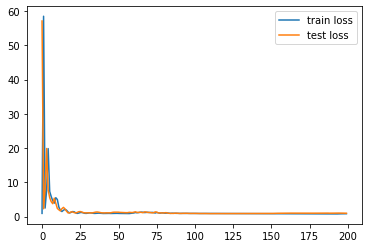

In [39]:
#Now I plot the test losses and train losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

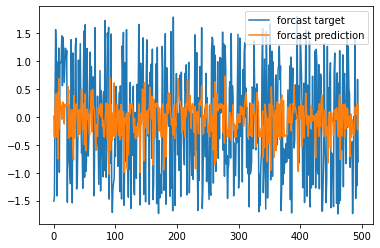

In [40]:
#Forcast with true targets
validation_target = Y
validation_prediction = []
i = 0
in_ = torch.from_numpy(X.astype(np.float32))
while len(validation_prediction) < len(validation_target):
    input_ = in_[i].reshape(1,T, 1)
    p = model(input_)[0,0].item()
    i += 1
    validation_prediction.append(p)
#Ploting forcast targets and forcast predictions
plt.plot(validation_target, label='forcast target')
plt.plot(validation_prediction, label='forcast prediction')
plt.legend()
plt.show()